# STAT 301 Final Report 
#### group members and date

In [19]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(httr))
suppressPackageStartupMessages(library(utils))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(knitr))
suppressPackageStartupMessages(library(MASS))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages (library(infer))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(glmnet))

## Introduction

- Relevant background information on the topic. Motivate the question you are about to add.
- Formulate one or two questions for investigation and detail the dataset that will be utilized to address these questions, indicating if the primary goal is inference or prediction.
- Make sure that the question(s) can be answer with the data available.
- Align your question/objectives with the existing literature.
- To contextualize your study, include a minimum of two scientific publications (these should be listed in the References section).

The question I want to analyze is: Which input variables are significantly associated with a student's placement status?  
All variables except `StudentID` and `PlacementStatus` (response variable) will be the input variables.

The primary focus of my question is inference because I am interested in analyzing the relationships between covariates and the response variable. 

## Methods and Results

### Data

- Read the data into R using reproducible code (i.e., from an open source and not a local directory in your server or computer)
- **Include a citation of its source**
- **Include any information you have about data collection (e.g., observational vs experimental)**
- Describe the variables as done in assignment 1
- If (absolutely) needed, indicate which variables will be pre-selected (or dropped) and provide a clear justification of your selection. Unless needed, you should use data-driven methods to select variables.

In [20]:
# load data
url <- "https://raw.githubusercontent.com/anniew02/stat301-final-project/main/placementdata.csv" 
raw_data <- read.csv(url)
head(raw_data, 5)

# check for null values in dataset (there are none)
anyNA(raw_data)

,StudentID,CGPA,Internships,Projects,Workshops.Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>
1,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
2,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
3,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
4,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
5,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


[1] FALSE

The [Placement Prediction Dataset](https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data) contains data which can be used to predict whether a college student gets placed or not placed in the placement process based on academic and training scores and status. The dataset contains 10000 observations and 12 variables as follows:  

**Numberical Variables:**
- `StudentID`: Unique student identifier (range 1-10000)
- `CGPA`: Cummulative grade point average achieved by each student (10-point scale)
- `Internships`: Number |of internships done by each student
- `Projects`: Number of projects done by each student
- `Workshops/Certifications`: Number of online workshops and certifications each student has participated in/received
- `AptitudeTestScores`: Aptitude test scores taken to understand a student's quant and logical thinking (100-point scale)
- `SoftSkillsRating`: Soft skills rating score to evaluate a student's communication skills (5-point scale)
- `SSC_Marks`: Senior Secondary Marks (100-point scale)
- `HSC_Marks`: Higher Secondary Marks (100-point scale)

**Categorical Variables:**
- `ExtracurricularActivities`: Binary (Yes/No) indicating whether each student participates in extracurricular activities or not
- `PlacementTraining`: Binary (Yes/No) indicating whether each student participated in placement training 
- `PlacementStatus`: Binary (Placed/NotPlaced) indicating whether each student was placed or not (response variable)

#### Pre-selection of variables

To start, I will drop the `StudentID` variable because it is a student identifier which tells us there is one observation per student. This will not be needed in analysis.

### Exploratory Data Analysis (EDA)

- Clean and wrangle your data into a tidy format.
- Include 2 effective and creative visualizations
- Explore the association of some potential explanatory variables with the response (use colours, point types, point size and/or faceting to include more variables)
- Highlight potential problems (e.g., multicollinearity or outliers)
- Transform some variables if needed and include a clear explanation (e.g. log-transformation may be useful when outliers are present)
- Plot the relevant raw data, tailoring your plot to address your question.
- Make sure to explore the association of the explanatory variables with the response.
- Any summary tables that are relevant to your analysis (e.g., summarize number of observation in groups, indicate if NAs exist).

In [21]:
data <- raw_data %>% 
    dplyr::select(-StudentID) %>%
    mutate(across(c(PlacementStatus, ExtracurricularActivities, PlacementTraining), as.factor)) %>%
    rename("WorkshopsCertifications" = "Workshops.Certifications")
head(data, 5)

,CGPA,Internships,Projects,WorkshopsCertifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


In [22]:
# split CGPA into quartiles
cgpa_quartiles <- data %>% 
    mutate(CGPA_quartiles = cut(CGPA,
                               breaks = quantile(CGPA, probs=c(0, 0.25, 0.50, 0.75, 1), na.rm=TRUE),
                               include.lowest=TRUE,
                               labels=c("Bottom 25%", "25-50%", "50-75%", "Top 25%")))

# cgpa_quartiles %>% count(CGPA_quartiles) #check quartile distribution
# data %>% count(Internships) #check internship distribution

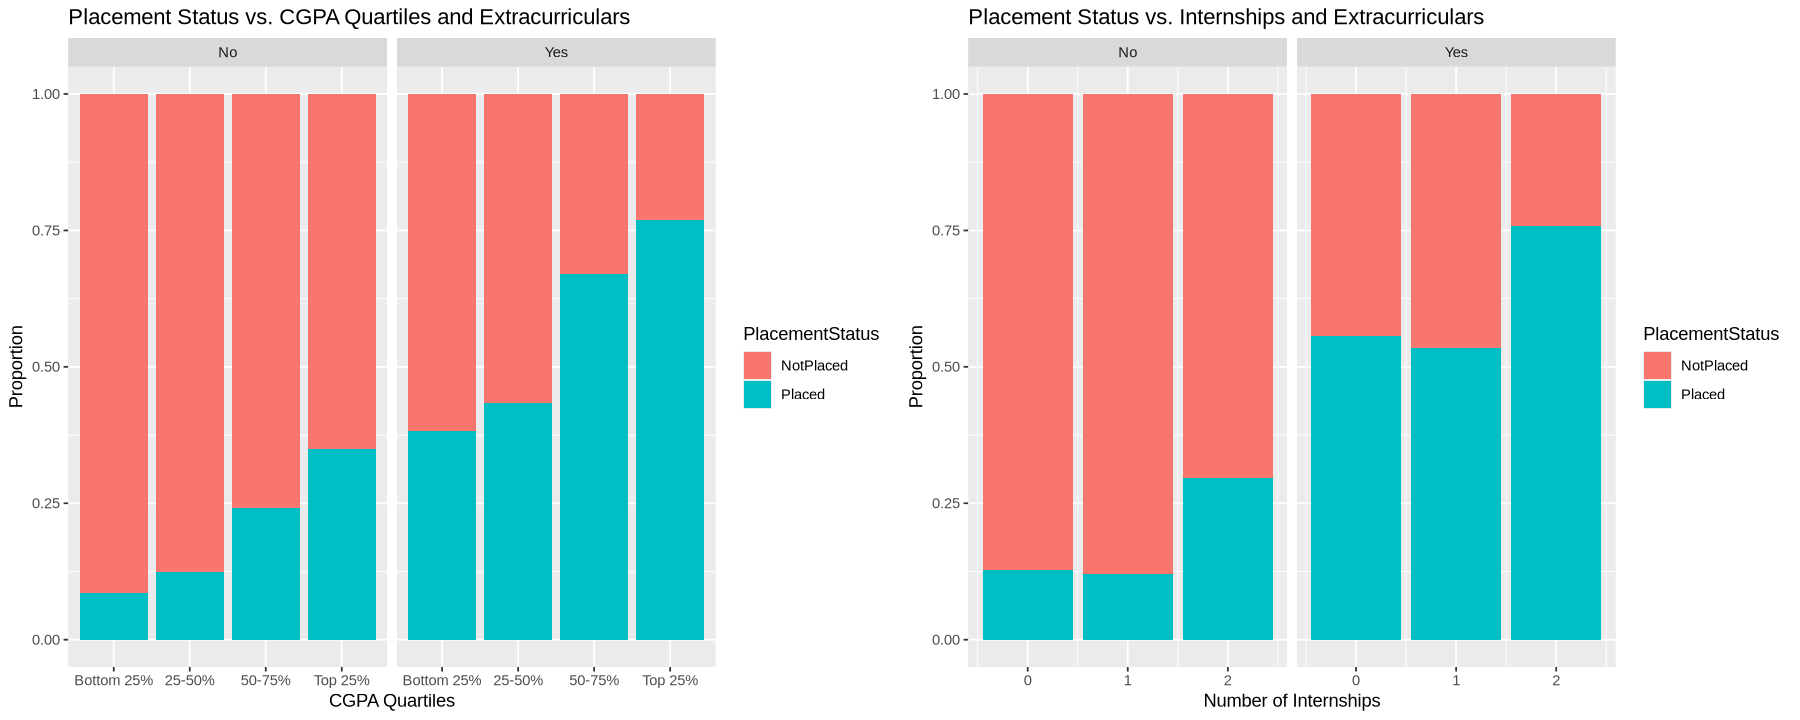

In [23]:
options(repr.plot.width = 15, repr.plot.height = 6)
p1 <- cgpa_quartiles %>% ggplot(aes(x=CGPA_quartiles, fill=PlacementStatus)) + 
        geom_bar(position="fill") +
        facet_wrap(~ExtracurricularActivities) +
        labs(title="Placement Status vs. CGPA Quartiles and Extracurriculars", 
             x="CGPA Quartiles", y="Proportion")
p2 <- data %>% ggplot(aes(x=Internships, fill=PlacementStatus)) +
        geom_bar(position="fill") +
        facet_wrap(~ExtracurricularActivities) +
        labs(title="Placement Status vs. Internships and Extracurriculars", 
             x="Number of Internships", y="Proportion")

# combined into 1 plot
plots <- plot_grid(p1, p2, ncol=2)
print(plots)

The plot to the left is a stacked bar plot that shows the proportion of students in each CGPA quartile who were placed/not placed in each extracurricular group (yes/no). It provides insights on how CGPA and extracurricular activities are associated with placement status. 

We observe that for students with no extracurricular activities, there's a greater proportion of students who were not placed in all CGPA quartiles. For students with extracurricular activities, a greater proportion of students in higher CGPA quartiles were placed and the proportions of placed and non-placed were similar for students with low-mid CGPA quartiles. **This suggests that CGPA and whether a student has extracurricular activities are associated with placement status.**

The plot on the right is a stacked bar plot that shows the proportion of students who did 0, 1, or 2 internships who were placed or not placed in each extracurricular group (yes/no). It provides insights on how the number of internships a student does and extracurricular activities are associated with placement status. 

We observe that for students with no extracurricular activities, there's a higher proportion of students who were not placed regardless of how many internships they did. For students with extracurricular activities, a higher proportion of students were placed for students, but the proportions for each number of internships are relatively similar. This suggests that the number of interships a student has done is not or weakly associated with placement status.

Some concerns so far are that the sample size of students who did 0, 1, and 2 internships is uneven which may distort the proportion of placement status.

*Note: see code comments and bolded text for changes incorporated from assignment 1 feedback.*

### Methods: Plan

- Describe in written English the methods you used to perform your analysis from beginning to end, and narrate the code that does the analysis.
- Provide a detailed justification of the method(s) used. The analysis must be based primarily on methods learned in the class (other method can be used for comparison).
- Make sure that the analysis responded the question posed and that the proposed method is appropriate for the characteristics of the data.
- If variable selection methods are used, justify the method used and explain what data will be used.
- If various models will be compared explain how you will select a final one.
- If included, describe the “Feature Selection” process and how and why you choose the covariates of your final model.
- Make sure to interpret/explain the results you obtain. 
- If inference is the aim of your project, a detailed interpretation of your fitted model is required, as well as a discussion of relevant quantities (e.g., which coefficient(s) is(are) statistically significant? interpretation of significant coefficients, How does the model fit the data)?
- A careful model assessment must be conducted.
- Include no more than 3 visualizations and/or tables to support your points. Ensure your tables and/or figures are labelled with a figure/table number and readable fonts.

#### Binomial Logisitic Regression Model
To address my question of interest, I plan to use a binomial logisitic regression model. Binomial logistic regression models are generally used to predict the probability of a binary outcome based on one or more predictor variables which is appropriate for my question because the response variable `PlacementStatus` is binary and there are multiple predictor variables which are numerical or categorical.

#### Model Assumptions
Assumptions made when using a binomial logistic regression model are that the observations are independent of each other, linearity between logit of the response and the covariates, and no multicollinearity between the covariates.

#### Limitations
Some possible limitations are that if there are correlations between variables related to academic scores and variables related to experential learning, then it may be difficult to seperate the effect of either factor. 

### Model Selection

I will improve this section in the final report, but for now I used stepwise selection in both directions to get guidance on which input variables to select in our logistic regression model. I chose to do stepwise selection in both directions because it's more robust as it adds or removes variables based on AIC.

In [24]:
# split the data
set.seed(875)

testing_data <- data %>%
  sample_frac(0.6, replace=FALSE) # experiment with this
training_data <- data %>%
  setdiff(testing_data)

head(training_data)

,CGPA,Internships,Projects,WorkshopsCertifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
3,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed
4,7.0,0,2,2,71,4.2,Yes,No,55,66,NotPlaced
5,7.4,0,2,1,78,4.4,No,No,63,66,NotPlaced
6,6.8,2,3,0,73,4.4,Yes,Yes,72,82,Placed


## Lasso Model

For our project, we chose the Lasso model for logistic regression because it simultaneously performs feature selection and shrinks coefficients, effectively eliminating irrelevant variables. While Lasso is excellent for training and selection, it introduces bias in coefficient estimates due to regularization. To address this, we will apply post-Lasso debiasing by fitting an unpenalized logistic regression model using only the variables selected by Lasso. This approach allows us to obtain unbiased coefficient estimates, making the model suitable for accurate inference.

In [25]:
training_data_lasso <- training_data |>
    mutate(PlacementStatus = if_else(PlacementStatus == "Placed", 1, 0)) |>
    mutate(PlacementTraining = if_else(PlacementTraining == "Yes",1,0)) |>
    mutate(ExtracurricularActivities = if_else(ExtracurricularActivities == "Yes", 1, 0))

testing_data_lasso <- testing_data |>
    mutate(PlacementStatus = if_else(PlacementStatus == "Placed", 1, 0)) |>
    mutate(PlacementTraining = if_else(PlacementTraining == "Yes",1,0)) |>
    mutate(ExtracurricularActivities = if_else(ExtracurricularActivities == "Yes", 1, 0))

In [26]:
x <- dplyr::select(training_data_lasso, -PlacementStatus)  |>
     as.matrix()
y <- training_data_lasso$PlacementStatus
lasso_cv <- cv.glmnet(x = x, y = y, family = "binomial", alpha = 1)

In [34]:
coef(lasso_cv, s = "lambda.min")

11 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)               -17.60813654
CGPA                        0.39940344
Internships                 .         
Projects                    0.29864806
WorkshopsCertifications     0.03969746
AptitudeTestScore           0.06572489
SoftSkillsRating            0.71957773
ExtracurricularActivities   0.63660979
PlacementTraining           0.93884643
SSC_Marks                   0.02645871
HSC_Marks                   0.02699795

Now, we apply post-Lasso debiasing by fitting a least-squares logistic regression model with no penalization, using the variables selected by Lasso

In [35]:
selected_vars <- c("CGPA", "Projects", "WorkshopsCertifications", "AptitudeTestScore", 
                   "SoftSkillsRating", "ExtracurricularActivities", "PlacementTraining", 
                   "SSC_Marks", "HSC_Marks")

logistic_model <- glm(PlacementStatus ~ ., data = training_data[, c("PlacementStatus", selected_vars)], 
                      family = "binomial")

summary(logistic_model)


Call:
glm(formula = PlacementStatus ~ ., family = "binomial", data = training_data[, 
    c("PlacementStatus", selected_vars)])

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -18.211885   0.830304 -21.934  < 2e-16 ***
CGPA                           0.416946   0.078143   5.336 9.52e-08 ***
Projects                       0.305634   0.058785   5.199 2.00e-07 ***
WorkshopsCertifications        0.049429   0.049863   0.991    0.322    
AptitudeTestScore              0.067222   0.007464   9.006  < 2e-16 ***
SoftSkillsRating               0.760328   0.133119   5.712 1.12e-08 ***
ExtracurricularActivitiesYes   0.655345   0.106794   6.137 8.44e-10 ***
PlacementTrainingYes           1.006968   0.112197   8.975  < 2e-16 ***
SSC_Marks                      0.027439   0.005027   5.458 4.81e-08 ***
HSC_Marks                      0.027006   0.006091   4.433 9.27e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’

Now we will analyze the 95% confidence intervals of covariates included in our logistic model

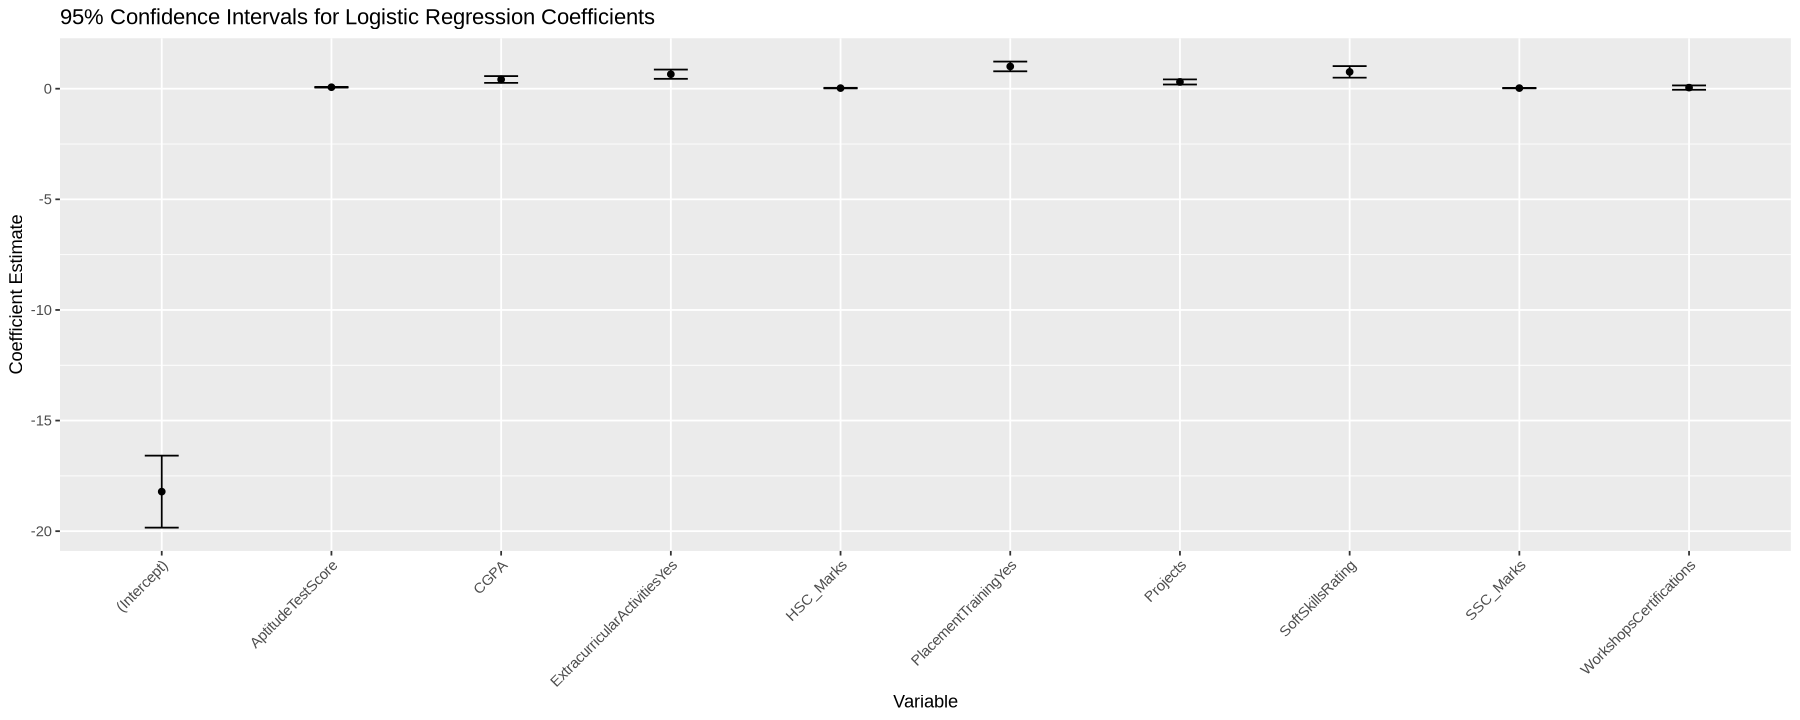

In [39]:
coefs <- summary(logistic_model)$coefficients[, 1]
std_errs <- summary(logistic_model)$coefficients[, 2]

ci_lower <- coefs - 1.96 * std_errs
ci_upper <- coefs + 1.96 * std_errs

coef_df <- data.frame(
  Variable = names(coefs),
  Estimate = coefs,
  CI_Lower = ci_lower,
  CI_Upper = ci_upper
)
library(ggplot2)

ggplot(coef_df, aes(x = Variable, y = Estimate)) +
  geom_point() + 
  geom_errorbar(aes(ymin = CI_Lower, ymax = CI_Upper), width = 0.2) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "95% Confidence Intervals for Logistic Regression Coefficients",
       x = "Variable", y = "Coefficient Estimate")


In [28]:
full_model <- glm(formula=PlacementStatus~., data=training_data, family=binomial)

In [29]:
# check for multicollinearity
vif_full <- vif(full_model)
vif_full

CGPA               Internships                  Projects 
                 1.224158                  1.134648                  1.332569 
  WorkshopsCertifications         AptitudeTestScore          SoftSkillsRating 
                 1.218580                  1.416318                  1.236120 
ExtracurricularActivities         PlacementTraining                 SSC_Marks 
                 1.293482                  1.016528                  1.319612 
                HSC_Marks 
                 1.473928

None of the VIF values are especially large which indicates there's no signs of multicollinearity in the data.

In [30]:
step_model <- stepAIC(full_model, 
                      direction="both",
                      trace=FALSE)
summary(step_model)


Call:
glm(formula = PlacementStatus ~ CGPA + Projects + AptitudeTestScore + 
    SoftSkillsRating + ExtracurricularActivities + PlacementTraining + 
    SSC_Marks + HSC_Marks, family = binomial, data = training_data)

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -18.412460   0.806716 -22.824  < 2e-16 ***
CGPA                           0.425080   0.077742   5.468 4.56e-08 ***
Projects                       0.308611   0.058711   5.256 1.47e-07 ***
AptitudeTestScore              0.067823   0.007442   9.113  < 2e-16 ***
SoftSkillsRating               0.768679   0.132884   5.785 7.27e-09 ***
ExtracurricularActivitiesYes   0.665144   0.106291   6.258 3.91e-10 ***
PlacementTrainingYes           1.003863   0.112101   8.955  < 2e-16 ***
SSC_Marks                      0.027837   0.005009   5.557 2.74e-08 ***
HSC_Marks                      0.027876   0.006026   4.626 3.73e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

The stepwise selection process removed `Internships` and `WorkshopsCertifications` from the full model which suggests that they're not as useful for making an inference on a student's placement status.

In [31]:
vif <- vif(step_model)
vif

CGPA                  Projects         AptitudeTestScore 
                 1.200056                  1.322038                  1.394001 
         SoftSkillsRating ExtracurricularActivities         PlacementTraining 
                 1.226001                  1.278693                  1.015466 
                SSC_Marks                 HSC_Marks 
                 1.309600                  1.441456

I checked for multicollinearity again after model selection and there still doesn't seem to be any signs of multicollinearity because none of the VIF values are especially large. This shows the multicollinearity assumption isn't violated.

### Model Implementation

In [32]:
logr_model <- glm(formula = PlacementStatus~.-Internships-WorkshopsCertifications,
             data=testing_data, 
             family=binomial)

tidy(logr_model, exponentiate=TRUE, conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.110246e-08,0.661716614,-27.679672,1.226765e-168,2.996147e-09,4.011299e-08
CGPA,1.478084e+00,0.065081273,6.003981,1.925376e-09,1.301331e+00,1.679612e+00
Projects,1.278682e+00,0.048144407,5.106093,3.288876e-07,1.163337e+00,1.405023e+00
AptitudeTestScore,1.077144e+00,0.005960149,12.468264,1.112225e-35,1.064678e+00,1.089851e+00
SoftSkillsRating,1.890438e+00,0.108508143,5.868761,4.390633e-09,1.528788e+00,2.339444e+00
ExtracurricularActivitiesYes,2.320165e+00,0.086164860,9.767766,1.548284e-22,1.959943e+00,2.747687e+00
PlacementTrainingYes,2.334072e+00,0.092645803,9.148976,5.747582e-20,1.948299e+00,2.801746e+00
SSC_Marks,1.031321e+00,0.004047564,7.619496,2.546680e-14,1.023173e+00,1.039540e+00
HSC_Marks,1.031450e+00,0.004856714,6.375824,1.819820e-10,1.021673e+00,1.041314e+00


After fitting the selected variables to a logistic regression model, it's observed that `CGPA`, `Projects`, `AptitudeTestScore`, `SoftSkillsRating`, `ExtracurricularActivitiesYes`, `PlacementTrainingYes`, `SSC_Marks`, and `HSC_Marks` are significantly associated with a student's placement status at 5% significance level because all these variables were selected in our stewpise model and their p-values are less than 0.05. 

In my exploratory analysis, I focused on the associations between a student's CGPA, extracurricular activities, and internships with their placement status and my analysis here agrees with my preliminary observations that there's evidence that CGPA and extracurricular activities are associated but not enough evidence for internships. The model indicates that a 1-point increase in a student's CGPA is associated with an increase the odds of being placed by a factor of 1.48 (48%) while holding all variables constant and students who participate in extracurricular activities are associated with increased odds of being placed by a factor of 2.32 (132%) compared to students without extracurricular activities while holding all other variables constant. It's unexpected that there was insufficient evidence of internships being associated with placement status because in real-life applications, I would expect work experience to be valuable when being placed. This could be due to underlying data limitations or the variation being explained by other variables.

## Discussion

- Interpret the results you obtained in the previous section with respect to the main question/goal of your project.
- Summarize what you found and the implications/impact of your findings.
- If relevant, discuss whether your results were what you expected to find.
- Discuss how your model could be improved;
- Discuss future questions/research this study could lead to.

## References

- At least two citations of literature relevant to the project.
- The citation format is your choice – just be consistent.
- Make sure to cite the source of your data as well.